In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm_notebook as tqn
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import warnings as wn

tqdm.pandas()
wn.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')
df.head()

,breedID,speciesID,fname,breed_name
0,23,2,0,newfoundland
1,35,2,1,staffordshire bull terrier
2,19,2,2,keeshond
3,2,2,3,american bulldog
4,29,2,4,saint bernard


Reading in images

In [3]:
df['image'] = df.fname.progress_apply(lambda x : plt.imread('image/train/{}.jpg'.format(x))/255)

100%|██████████| 3680/3680 [00:53<00:00, 69.39it/s] 


Reshaping images for Resnet

In [4]:
df.image = df.image.progress_apply(lambda x: resize(x, (224,320)))

100%|██████████| 3680/3680 [03:11<00:00, 19.26it/s]


In [9]:
df.image[0].shape

(3, 333, 500)

In [5]:
def process_img(x):
    img_new = x.reshape(x.shape[2],x.shape[0],x.shape[1])
    return img_new[:3,:,:]  # removing 4 channel images

df.image = df.image.apply(process_img)

Train test split

ValueError: all input arrays must have the same shape

In [6]:
X = np.stack(df.image.values).astype(np.double)
y = df.breedID.values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [7]:
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train).long()
X_val = torch.from_numpy(X_val)
y_val = torch.from_numpy(y_val).long()

train_set = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_set, batch_size=64)
val_set = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_set, batch_size=64)

### Training model

In [8]:
epochs = 30
lr = 0.01
wd = 0.0001
mt = 0.9
SAVE_PATH = 'dog_cat.ct'

In [11]:
model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet18', pretrained=False, num_classes=37)

Using cache found in /Users/devanshu/.cache/torch/hub/pytorch_vision_v0.4.2


In [12]:
best_loss = float('inf')
epoch_train_losses = []
epoch_val_losses = []
criterion = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=mt)

for _ in tqn(range(epochs)):
    train_losses = []
    val_losses = []
    
    for data, target in tqn(train_loader):
        opt.zero_grad()
        t_loss = criterion(model(data.float()), target-1)
        train_losses.append(t_loss.item())
        t_loss.backward()
        opt.step()
    epoch_train_losses.append(np.mean(train_losses))
    
    for data, target in val_loader:
        opt.zero_grad()
        v_loss = criterion(model(data.float()), target-1)
        val_losses.append(v_loss.item())
    mean_val_loss = np.mean(val_losses)
    epoch_val_losses.append(mean_val_loss)
    if mean_val_loss < best_loss:
        best_loss = mean_val_loss
        torch.save(model.state_dict(), SAVE_PATH)

KeyboardInterrupt: 

In [23]:
best_model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet152', pretrained=False, num_classes=37)

Using cache found in /Users/devanshu/.cache/torch/hub/pytorch_vision_v0.4.2


In [24]:
best_model.load_state_dict(torch.load('dog_cat.ct'))

<All keys matched successfully>

In [25]:
best_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

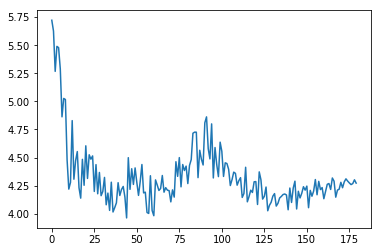

In [22]:
x = np.arange(epochs)
plt.plot(x, epoch_train_losses, 'r');
plt.plot(x, epoch_val_losses, 'g');

In [26]:
res = best_model(X_val.float())